In [115]:
import numpy as np
from scipy import ndimage
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import math

In [116]:
def read_images(image_path):
    # img = cv2.imread(image_path)
    # rescaled_image  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(float)/255
    img = Image.open(image_path).convert('L')
    img = np.array(img).astype(float) / 255.0
    return img

### Scale Space by increasing Sigma

In [117]:

def check_for_odd_sigma(sigma):
    return sigma

def  generate_scale_space(image, initial_sigma, constant_multiplier, iterations):
    current_sigma = initial_sigma
    height = image.shape[0]
    width = image.shape[1]
    scale_space = np.empty((height, width, iterations))
    sigma_values = []
    for i in range(0, iterations):
        print(current_sigma)
        sigma_values.append(current_sigma)
        LoG_response = ndimage.gaussian_laplace(image, current_sigma,mode="nearest")
        sigma_normalized_LoG =  np.square(current_sigma) * LoG_response
        scale_space[:,:,i] = np.square(sigma_normalized_LoG)
        current_sigma = check_for_odd_sigma(math.ceil(constant_multiplier * current_sigma))

    return scale_space, sigma_values

In [156]:
def supress_function(image_window):
    middle_index = math.floor(image_window.shape[0]/2)
    return image_window[middle_index] if image_window[middle_index] == np.max(image_window) else 0

def non_maximum_suppression(scale_space, window_size):
    suppressed_space = np.empty((scale_space.shape[0],scale_space.shape[1],scale_space.shape[2]))

    for i in range(scale_space.shape[2]):
        suppressed_space[:,:,i] = ndimage.generic_filter(scale_space[:,:,i],function=supress_function, footprint=np.ones((window_size,window_size)))
    return suppressed_space

def non_maximum_sup_scale_space(scale_space):
    suppressed_space = np.empty((scale_space.shape[0],scale_space.shape[1],scale_space.shape[2]))
    for i in range(scale_space.shape[2]):
         y = ndimage.rank_filter(scale_space[:,:,max(0,i-2):min(scale_space.shape[2],i+3)], rank=-1, size=(7,7,min(scale_space.shape[2],i+3)-max(0,i-2)+1))
         suppressed_space[:,:,i] = y[:,:,-1]

    new_suppressed_scale_space = scale_space *  (np.array(suppressed_space == scale_space).astype(int))

    return new_suppressed_scale_space

In [157]:
def find_optimal_scale(scale_space):
    return np.argmax(scale_space, axis=2), np.amax(scale_space, axis=2)

In [158]:
constant_scale_factor = 1.25
initial_sigma = 2
image_path = 'butterfly.jpg'
img = read_images(image_path)
scale_space, sigma_values = generate_scale_space(img , initial_sigma, constant_scale_factor, 15 )

2
3
4
5
7
9
12
15
19
24
30
38
48
60
75


In [159]:
suppress_window = 13
suppressed_responses = non_maximum_suppression(scale_space, suppress_window)
# maximum_sigma_by_axis, maximum_response_prev = find_optimal_scale(suppressed_responses)

In [160]:
suppressed_sp = non_maximum_sup_scale_space(suppressed_responses)

In [161]:
coordinates = np.where(suppressed_sp > .007)

In [162]:
def show_all_circles(image, cx, cy, rad, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, (pow(constant_scale_factor,rad) * initial_sigma)):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    plt.show()

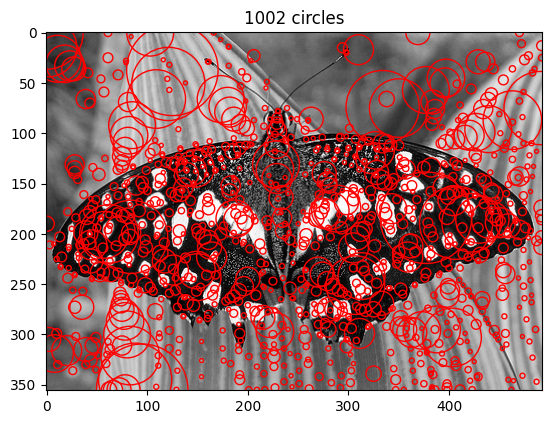

In [163]:
show_all_circles(read_images(image_path),coordinates[1],coordinates[0],coordinates[2])